In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from stkm.TKM import TKM
from cv_stkm import (generate_input_data, return_bbox_image, 
                     train_json_to_df, compare_true_vs_predicted_mask, scaled_mask_from_bbox, get_image)
import numpy as np


/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
from torchvision import models, transforms
from torch.autograd import Variable
import torch

model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-2]))  # Keep the spatial dimensions in the output
model.eval()

# Image transformation pipeline
preprocess = transforms.Compose([
    transforms.Resize((224,224)),  # Change this to the size of your images if you want to maintain the same resolution
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



In [3]:
df = pd.read_pickle('stgkm_computer_vision_df_cosine.pkl')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'stgkm_computer_vision_df_cosine.pkl'

In [129]:
len(df)

436

In [130]:
np.mean(df['avg_jaccard_index'])

0.5378448960152492

In [143]:
np.median(df['avg_jaccard_index'])

0.5660866327747874

(array([ 12.,  16.,  22.,  31.,  91., 137.,  96.,  26.,   4.,   1.]),
 array([0.06818453, 0.16044015, 0.25269577, 0.34495139, 0.43720701,
        0.52946264, 0.62171826, 0.71397388, 0.8062295 , 0.89848512,
        0.99074074]),
 <BarContainer object of 10 artists>)

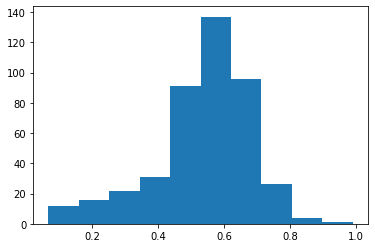

In [131]:
plt.hist(df['avg_jaccard_index'])

In [98]:
annotation_df, video_df = train_json_to_df(json_path='cv_data/vis-train/train.json')

In [99]:
#find average size of bounding boxes in dataset 

# annotation_df['bboxes']

In [144]:
# poor_files = df[(df['avg_jaccard_index']<=.90) & (df['avg_jaccard_index']>=.80)]['root_filename'].unique()
poor_files = df[(df['avg_jaccard_index']<=.20)]['root_filename'].unique()

print('Number of files with poor performance ', len(poor_files))
file_num = -1
print(poor_files[file_num], df[df['root_filename'] == poor_files[file_num]])



Number of files with poor performance  21
8273a03530     root_filename  avg_jaccard_index   runtime
435    8273a03530           0.198591  0.661631


In [145]:
poor_files

array(['f2fdb6abec', 'cbb410da64', '2038987336', 'a2c996e429',
       '3543d8334c', 'aa07b7c1c0', '26de3d18ca', 'b53f675641',
       'c30a7b62c9', 'e71629e7b5', 'ed7455da68', 'e3bf38265f',
       'cff8191891', '5e8d59dc31', 'd3069da8bb', 'ca346f17eb',
       'ea5672ffa8', '15617297cc', 'cad8a85930', 'f4dd51ac35',
       '8273a03530'], dtype=object)

In [158]:
#questionable: 2038987336- we track the alligator they don't, 
#f2fdb6abec - we don't see the tiny fish
#aa6287bb6c - we track the bus, not the car
#a14f709908 - they zero in on one bird 
#ca346f17eb
#lots of small objects but our resolution is quite large
#actually bad: aa07b7c1c0, b53f675641, c30a7b62c9, e3bf38265f

############
#intriguing: 6bf2e853b1
#lose the monkey: 29a0356a2b

#This one is really good, but for not good reason fb23455a7f

filename = '5e8d59dc31' #poor_files[file_num]
dir_name = 'cv_data/train/JPEGImages/' + filename + '/'
image_paths, input_data = generate_input_data(dir_name)

tkm = TKM(input_data)
tkm.perform_clustering(num_clusters=2, lam=.8, max_iter=1000, init_centers = 'kmeans_plus_plus')

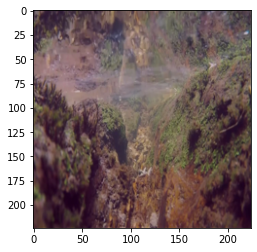

In [170]:
return_bbox_image(root_filename = filename,
                  image_paths = image_paths, 
                  index = 5,
                  annotation_df = annotation_df,
                  video_df = video_df, 
#                   weights = tkm.weights, 
                 scale_to_grid = True)



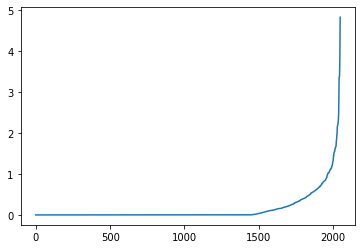

In [178]:
input_sorted = np.sort(input_data[0,:, 0])
plt.plot(input_sorted)

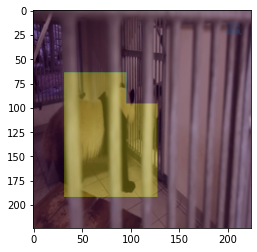

In [139]:
from cv_stkm import return_predicted_masked_image

return_predicted_masked_image(image_paths = image_paths, 
                             index = 10, 
                             weights = tkm.weights)

In [325]:
relevant_video = video_df[video_df['root_filename'] == filename]
relevant_annotations = annotation_df[annotation_df['video_id'] == relevant_video['id'].values[0]]
og_image, og_size = get_image(image_path = image_paths[0])
og_cols, og_rows = og_size

#length of tracked objects can vary 
true_bboxes = relevant_annotations['bboxes'].values[0]
weights = tkm.weights

jaccard_indices = []
for index, true_bbox in enumerate(true_bboxes):
    mask = np.argmax(weights[index], axis = 1).reshape((7,7))
    extended_mask = np.repeat(np.repeat(mask, 32, axis=0), 32, axis=1)

#     jaccard_index, true_mask = compare_true_vs_predicted_bboxes(true_bbox = true_bbox,
#                                      predicted_bbox = extended_mask,
#                                      og_cols = og_cols,
#                                      og_rows = og_rows)

    if true_bbox is None:
        true_mask = np.zeros((224,224))
    else:
        y_scale = 224/og_cols
        x_scale = 224/og_rows

        y = int(np.round(true_bbox[0]*y_scale))
        x = int(np.round(true_bbox[1]*x_scale))
        h = int(np.round(true_bbox[2]*y_scale))
        w = int(np.round(true_bbox[3]*x_scale))
        true_mask = np.zeros((224,224))
        true_mask[x: x+w,:][:, y:y+h] = 1
    
    flat_true_mask = true_mask.reshape(1,-1)
    flat_predicted_bbox = extended_mask.reshape(1,-1)
    
    max_jaccard_index = 0
    
    for cluster in np.unique(flat_predicted_bbox):
        #[1] to take into account the first dimension of flattened masks
        cluster_pixels = np.where(flat_predicted_bbox == cluster)[1]

        #Not where they're equal, but how many values they have in common
        intersection = len(np.intersect1d(np.nonzero(flat_true_mask)[1], cluster_pixels, assume_unique = True))
        #Size of individual masks minus their overlap
        union = np.sum(true_mask == 1) + np.sum(extended_mask == cluster) - intersection
        jaccard_index = intersection/union
        print(len(np.where(true_mask == 1)[0]), len(np.where(extended_mask == cluster)[0]))
        if jaccard_index > max_jaccard_index:
            print('intersection, union', intersection, union)
            max_jaccard_index = jaccard_index
    jaccard_indices.append(max_jaccard_index)
    
print(jaccard_indices)
    

49952 41984
intersection, union 41760 50176
49952 8192
50176 41984
intersection, union 41984 50176
50176 8192
50176 43008
intersection, union 43008 50176
50176 7168
49952 45056
intersection, union 44832 50176
49952 5120
50176 45056
intersection, union 45056 50176
50176 5120
50176 46080
intersection, union 46080 50176
50176 4096
50176 45056
intersection, union 45056 50176
50176 5120
50176 46080
intersection, union 46080 50176
50176 4096
49952 45056
intersection, union 44832 50176
49952 5120
50176 44032
intersection, union 44032 50176
50176 6144
49952 44032
intersection, union 43808 50176
49952 6144
49952 44032
intersection, union 43808 50176
49952 6144
50176 46080
intersection, union 46080 50176
50176 4096
50176 46080
intersection, union 46080 50176
50176 4096
49952 44032
intersection, union 43808 50176
49952 6144
50176 46080
intersection, union 46080 50176
50176 4096
50176 45056
intersection, union 45056 50176
50176 5120
49952 44032
intersection, union 43808 50176
49952 6144
50176 4505